# Dipole
This example reproduces the topology constraint.

In [1]:
from quadcoil import quadcoil

from simsopt.mhd import Vmec
from simsopt import load
from simsopt.field import CurrentPotentialFourier, CurrentPotentialSolve
import jax
import vmecpp
import os
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import block_until_ready, devices, config
import time
devices()

[CudaDevice(id=0), CudaDevice(id=1)]

## Loading files

In [2]:
# Loading muse++ equilibrium into VMEC
# filename_pp = "wout_muse++.nc"
# equil_pp = Vmec(filename_pp, keep_all_files=True)
# plasma_surface = equil_pp.boundary
# net_poloidal_current_amperes = equil_pp.external_current()

# Loading NCSX
winding_surface, plasma_surface = load('surfaces.json')
net_poloidal_current_amperes = 11884578.094260072
mpol = 4
ntor = 4
jax.config.update('jax_enable_x64', True)

/home/lankef/code/simsopt/src/simsopt/_core/optimizable.py:1630: EncodingWarning: We strongly encourage explicit `encoding`, and we would use UTF-8 by default as per PEP 686
  with zopen(filename, "rt") as fp:


# Problem settings

In [3]:
# Settings 
separation = 0.1
mpol = 12
ntor = 12
nfp = plasma_surface.nfp
plasma_M_theta = 16
plasma_N_phi = 32

## Running a REGCOIL scan

In [4]:
if not os.path.exists('regcoil.npy'):
    # We scan the REGCOIL regularization factor and recover the 
    # dipole distribution Caoxiang's paper chose
    f_B_test_list = []
    phi_test_list = []
    f_K_test_list = []
    time_quadcoil_list = []
    time_regcoil_list = []
    phi_ans_list = []
    f_B_ans_list = []
    f_K_ans_list = []
    for i in 10**np.linspace(-20, -10, 20):
        # Run QUADCOIL first
        time1 = time.time()
        regcoili_out_dict, regcoili_qp, regcoili_phi_mn, status = quadcoil(
            nfp=plasma_surface.nfp,
            stellsym=plasma_surface.stellsym,
            mpol=mpol,
            ntor=ntor,
            plasma_dofs=plasma_surface.get_dofs(),
            plasma_mpol=plasma_surface.mpol,
            plasma_ntor=plasma_surface.ntor,
            net_poloidal_current_amperes=net_poloidal_current_amperes,
            net_toroidal_current_amperes=0.,
            plasma_coil_distance=separation,
            objective_name=('f_B', 'f_K'),
            objective_weight=np.array([1., i]),
            objective_unit=(1., 1.),
            metric_name=('f_B', 'f_K'),
        )
    
        phi_test_list.append(regcoili_phi_mn)
        f_B_test_list.append(regcoili_out_dict['f_B']['value'])
        f_K_test_list.append(regcoili_out_dict['f_K']['value'])
        time2 = time.time()
        time_quadcoil_list.append(time2-time1)
        print('i =', i, '| time =', time2-time1)
    
        wsi = regcoili_qp.winding_surface.to_simsopt()
        psi = regcoili_qp.plasma_surface.to_simsopt()
        cpi = CurrentPotentialFourier(
            wsi, mpol=mpol, ntor=ntor,
            net_poloidal_current_amperes=net_poloidal_current_amperes,
            net_toroidal_current_amperes=0.,
            stellsym=True)
        cpsti = CurrentPotentialSolve(cpi, psi, 0)
        regcoili_phi_mn_ans, regcoili_f_B_ans, regcoili_f_K_ans = cpsti.solve_tikhonov(i)
        time2 = time.time()
        time_regcoil_list.append(time2-time1)
        phi_ans_list.append(regcoili_phi_mn_ans)
        f_B_ans_list.append(regcoili_f_B_ans)
        f_K_ans_list.append(regcoili_f_K_ans)
        
    print('QUADCOIL avg time:', np.average(time_quadcoil_list), '(s)')
    print('QUADCOIL max time:', np.max(time_quadcoil_list), '(s)')
    print('REGCOIL avg time:', np.average(time_regcoil_list), '(s)')
    print('REGCOIL max time:', np.max(time_regcoil_list), '(s)')
    time_regcoil_list = np.array(time_regcoil_list)
    phi_ans_list = np.array(phi_ans_list)
    f_B_ans_list = np.array(f_B_ans_list)
    f_K_ans_list = np.array(f_K_ans_list)
    time_quadcoil_list = np.array(time_quadcoil_list)
    phi_test_list = np.array(phi_test_list)
    f_B_test_list = np.array(f_B_test_list)
    f_K_test_list = np.array(f_K_test_list)
    jnp.save('regcoil.npy',{
        'regcoili_qp': regcoili_qp,
        'time_regcoil_list': time_regcoil_list,
        'phi_ans_list': phi_ans_list,
        'f_B_ans_list': f_B_ans_list,
        'f_K_ans_list': f_K_ans_list,
        'time_quadcoil_list': time_quadcoil_list,
        'phi_test_list': phi_test_list,
        'f_B_test_list': f_B_test_list,
        'f_K_test_list': f_K_test_list,
    })
    # Is quadcoil really well-behaved than regcoil?
    print('Quadcoil seems to be more well-behaved than regcoil.')    
    from quadcoil.objective import f_B
    print('quadcoil f_B', f_B(regcoili_qp, phi_test_list[0]))
    print('regcoil  f_B', f_B(regcoili_qp, phi_ans_list[0]))
    plt.plot(phi_test_list[0], label='regcoil')
    plt.plot(phi_ans_list[0], label='quadcoil', linestyle='dashed')
    plt.legend()
    plt.show()
else:
    dict = jnp.load('regcoil.npy', allow_pickle=True).item()
    regcoili_qp = dict['regcoili_qp']
    time_regcoil_list = dict['time_regcoil_list']
    phi_ans_list = dict['phi_ans_list']
    f_B_ans_list = dict['f_B_ans_list']
    f_K_ans_list = dict['f_K_ans_list']
    time_quadcoil_list = dict['time_quadcoil_list']
    phi_test_list = dict['phi_test_list']
    f_B_test_list = dict['f_B_test_list']
    f_K_test_list = dict['f_K_test_list']

f_K at the inflection point: 34650090000000.0
f_B at the inflection point: 0.008624175


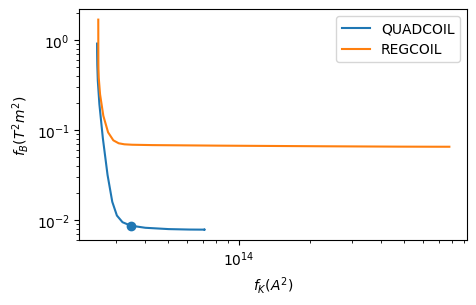

In [5]:
# inflection point
i_infl = np.argmin(f_K_test_list * f_B_test_list)
plt.figure(figsize=(5,3))
plt.plot(f_K_test_list, f_B_test_list, label='QUADCOIL')
plt.plot(f_K_ans_list, f_B_ans_list, label='REGCOIL')
plt.ylabel('$f_B(T^2m^2)$')
plt.xlabel('$f_K(A^2)$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.scatter(f_K_test_list[i_infl], f_B_test_list[i_infl])
print('f_K at the inflection point:', f_K_test_list[i_infl])
print('f_B at the inflection point:', f_B_test_list[i_infl])
f_B_target = f_B_test_list[i_infl]
phi_regcoil = phi_test_list[i_infl]

## Dipole layer thickness optimization
Here, we constrain the field error, and target the maximum 
magnitude of the dipole density over the surface

In [6]:
# Calculating normalization factors
from quadcoil.objective import f_max_Phi2, f_B, f_max_Phi, Phi
# Auto-normalization will not work for dipole objectives,
# because they are zero when Phi is 0.
# Therefore, we choose instead to normalize
# using the Phi measured from the inflection point.
unit_Phi2 = f_max_Phi2(regcoili_qp, phi_test_list[i_infl])
print('Max(Phi^2) =', unit_Phi2, 'At the inflection point.')
unit_Phi = f_max_Phi(regcoili_qp, phi_test_list[i_infl])
print('Max(Phi) =', unit_Phi, 'At the inflection point.')

Max(Phi^2) = 286467060000.0 At the inflection point.
Max(Phi) = 535226.2 At the inflection point.


In [7]:

# Lesson: It's not good to force switch using maxiter. 
# We want to use a 
numerical_kwargs = {
    'maxiter_inner':1000,
    'c_growth_rate':100,
    'fstop_inner':1e-7,
    'gtol_inner':1e-7,
    'gtol_inner_fin':1e-8,
    'grad_l_stop_outer':0.,
}

In [8]:
# Solving with the quadcoil default function
out_dict, qp, phi_mn, status = quadcoil(
    nfp=plasma_surface.nfp,
    stellsym=plasma_surface.stellsym,
    # plasma_coil_distance=separation,
    mpol=mpol,
    ntor=ntor,
    plasma_dofs=plasma_surface.get_dofs(),
    plasma_mpol=plasma_surface.mpol,
    plasma_ntor=plasma_surface.ntor,
    net_poloidal_current_amperes=net_poloidal_current_amperes,
    net_toroidal_current_amperes=0.,
    metric_name='f_max_Phi',
    objective_name='f_max_Phi2', # Minimizing peak dipole density
    objective_unit=unit_Phi2, # under an f_B constraint
    constraint_name=('f_B',),
    constraint_type=('<=',),
    constraint_unit=(f_B_target,),
    constraint_value=np.array([f_B_target,]),
    verbose=2,
    **numerical_kwargs
)

Running QUADCOIL in verbose mode 

----- Input summary ----- 
Evaluation phi quadpoint num: 32
Evaluation theta quadpoint num: 34
Plasma phi quadpoint num: 32
Plasma theta quadpoint num: 34
Winding phi quadpoint num: 96
Winding theta quadpoint num: 34
Net poloidal current (A): 11884578.094260072
Net toroidal current (A): 0.0
Constraint names: ('f_B',)
Constraint types: ('<=',)
Constraint units: (Array(0.00862417, dtype=float32),)
Constraint values: [0.00862417]
Objective names: f_max_Phi2
Objective units: 286467063808.0
Objective weights: None
Numerical parameters:
    c_init: 1.0
    c_growth_rate: 100
    grad_l_stop_outer: 0.0
    xstop_outer: 0.0
    gtol_outer: 1e-07
    ctol_outer: 1e-07
    fstop_inner: 1e-07
    xstop_inner: 0.0
    gtol_inner: 1e-07
    gtol_inner_fin: 1e-08
    maxiter_tot: 10000
    maxiter_inner: 1000
Plasma-coil distance (m): 0.1
OUTER: 
    Iteration: 0/10000
    Stopping criteria - (outer_dgrad_l >= grad_l_stop_outer):True
    Stopping criteria - (dx_out

ERROR:2025-04-14 15:50:48,366:jax._src.callback:96: jax.pure_callback failed
Traceback (most recent call last):
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/jax/_src/callback.py", line 94, in pure_callback_impl
    return tree_util.tree_map(np.asarray, callback(*args))
                                          ^^^^^^^^^^^^^^^
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/jax/_src/callback.py", line 71, in __call__
    return tree_util.tree_leaves(self.callback_func(*args, **kwargs))
                                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/equinox/_errors.py", line 89, in raises
    raise _EquinoxRuntimeError(
equinox._errors._EquinoxRuntimeError: A linear solver received non-finite (NaN or inf) input and cannot determine a 
solution. 

This means that you have a bug upstream of Lineax and should check the inputs to 
`lineax.linear_solve` for non

grad_l_val: nan, d_grad_l_val: nan, grad_f_val: nan, min and max mu:nan, nan, inner iter #: 15
c_k: 1e+38, max|h_eq|: 0.0, max|gplus|: nan
INNER: g0_norm: 0.1467349426806653, g0_norm * tol: 1.4673494268066531e-08
OUTER: 
    Iteration: 664/10000
    Stopping criteria - (outer_dgrad_l >= grad_l_stop_outer):False
    Stopping criteria - (dx_outer >= xstop_outer):           False
    Stopping criteria - KKT conditions:                      False
    KKTs - False, False, False, False, False, False
Metric evaluated. f_max_Phi = nan
Metric evaluated2. f_max_Phi = nan
grad_l_val: nan, d_grad_l_val: nan, grad_f_val: nan, min and max mu:nan, nan, inner iter #: 1
c_k: 1e+40, max|h_eq|: 0.0, max|gplus|: nan
----- Solver status summary -----
Final value of objective f: nan
Final Max current potential (dipole density): nan (A)
Final Avg current potential (dipole density): nan (A)
* Total L-BFGS iteration number: 665
    Init value of phi scaling constant:  239156.12177698663(A)
    Final value of p

E0414 15:50:48.368362 1575253 pjrt_stream_executor_client.cc:3086] Execution of replica 0 failed: INTERNAL: CustomCall failed: CpuCallback error: Traceback (most recent call last):
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/runpy.py", line 198, in _run_module_as_main
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/runpy.py", line 88, in _run_code
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/asyncio/base_events.py", line 645, in run_forever
  File "/home/

XlaRuntimeError: INTERNAL: CustomCall failed: CpuCallback error: Traceback (most recent call last):
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/runpy.py", line 198, in _run_module_as_main
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/runpy.py", line 88, in _run_code
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/asyncio/base_events.py", line 645, in run_forever
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/asyncio/base_events.py", line 1999, in _run_once
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/asyncio/events.py", line 88, in _run
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
  File "/tmp/ipykernel_1575253/2565346935.py", line 2, in <module>
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/jax/_src/traceback_util.py", line 180, in reraise_with_filtered_traceback
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/jax/_src/pjit.py", line 337, in cache_miss
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/jax/_src/pjit.py", line 195, in _python_pjit_helper
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/jax/_src/pjit.py", line 1695, in _pjit_call_impl_python
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/jax/_src/profiler.py", line 333, in wrapper
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/jax/_src/interpreters/pxla.py", line 1289, in __call__
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/jax/_src/interpreters/mlir.py", line 2854, in _wrapped_callback
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/jax/_src/callback.py", line 286, in _callback
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/jax/_src/callback.py", line 97, in pure_callback_impl
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/jax/_src/callback.py", line 71, in __call__
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/equinox/_errors.py", line 89, in raises
_EquinoxRuntimeError: A linear solver received non-finite (NaN or inf) input and cannot determine a 
solution. 

This means that you have a bug upstream of Lineax and should check the inputs to 
`lineax.linear_solve` for non-finite values.


--------------------
An error occurred during the runtime of your JAX program! Unfortunately you do not appear to be using `equinox.filter_jit` (perhaps you are using `jax.jit` instead?) and so further information about the error cannot be displayed. (Probably you are seeing a very large but uninformative error message right now.) Please wrap your program with `equinox.filter_jit`.
--------------------


In [ ]:
print('f_B from REGCOIL:      ', f_B(regcoili_qp, phi_test_list[i_infl]))
print('f_B from QUADCOIL:     ', f_B(qp, phi_mn))
f_Phi_crtl = f_max_Phi(regcoili_qp, phi_test_list[i_infl])
f_Phi_1 = f_max_Phi(qp, phi_mn)
print('Max dipole dens from REGCOIL:      ', f_Phi_crtl)
print('Max dipole dens from QUADCOIL:     ', f_Phi_1, round((f_Phi_crtl-f_Phi_1)/f_Phi_crtl*100, 3), '% improvement')

phi_regcoil = Phi(qp, phi_test_list[i_infl])
phi_quadcoil = Phi(qp, phi_mn)
cmin = np.min([phi_regcoil, phi_quadcoil])
cmax = np.max([phi_regcoil, phi_quadcoil])

fig, axes = plt.subplots(1, 2, figsize=(6, 3), constrained_layout=True)

# Plot for REGCOIL
im0 = axes[0].contour(phi_regcoil, vmin=cmin, vmax=cmax, cmap = 'seismic', levels=20)
axes[0].set_title(r'REGCOIL\n$\Phi_{max}$='+str(int(f_Phi_crtl))+'A')

# Plot for QUADCOIL
im1 = axes[1].contour(phi_quadcoil, vmin=cmin, vmax=cmax, cmap = 'seismic', levels=20)
axes[1].set_title(r'QUADCOIL\n$\Phi_{max}$='+str(int(f_Phi_1))+'A')



# Add colorbar with better positioning
cbar = fig.colorbar(im1, ax=axes, orientation='vertical', shrink=1., aspect=25, pad=0.05)
cbar.set_label("Dipole Density (A)")

plt.show()


## Dipole sparsity optimization
Here, we constrain the field error and maximum dipole density, 
and target the L-1 norm of the dipole over the surface.

In [10]:
# Calculating normalization factor for L1 regularized
from quadcoil.objective import f_l1_Phi
unit_l1 = f_l1_Phi(qp, phi_mn)
unit_l1

Array(2767931.85555017, dtype=float64)

In [11]:
# Solving with the quadcoil default function
l1_out_dict, l1_qp, l1_phi_mn, l1_status = quadcoil(
    nfp=plasma_surface.nfp,
    stellsym=plasma_surface.stellsym,
    plasma_coil_distance=separation,
    mpol=mpol,
    ntor=ntor,
    plasma_dofs=plasma_surface.get_dofs(),
    plasma_mpol=plasma_surface.mpol,
    plasma_ntor=plasma_surface.ntor,
    net_poloidal_current_amperes=net_poloidal_current_amperes,
    net_toroidal_current_amperes=0.,
    metric_name='f_B',
    objective_name='f_l1_Phi', # Minimizing the L1 norm of Phi
    objective_unit=unit_l1, # under an f_B, max Phi constraint
    constraint_name=('f_B', 'f_max_Phi',),
    constraint_type=('<=', '<=',),
    constraint_unit=(f_B_target, f_Phi_crtl,),
    constraint_value=np.array([f_B_target, f_Phi_crtl,]),
    verbose=3,
    **numerical_kwargs
)

Running QUADCOIL in verbose mode 

----- Input summary ----- 
Evaluation phi quadpoint num: 32
Evaluation theta quadpoint num: 34
Plasma phi quadpoint num: 32
Plasma theta quadpoint num: 34
Winding phi quadpoint num: 96
Winding theta quadpoint num: 34
Net poloidal current (A): 11884578.094260072
Net toroidal current (A): 0.0
Constraint names: ('f_B', 'f_max_Phi')
Constraint types: ('<=', '<=')
Constraint units: (Array(0.00862417, dtype=float32), Array(535226.2, dtype=float32))
Constraint values: [8.624175e-03 5.352262e+05]
Objective names: f_l1_Phi
Objective units: 2767931.8555501653
Objective weights: None
Numerical parameters:
    c_init: 1.0
    c_growth_rate: 1.2
    grad_l_stop_outer: 1e-10
    xstop_outer: 0.0
    gtol_outer: 1e-07
    ctol_outer: 1e-07
    fstop_inner: 1e-07
    xstop_inner: 0.0
    gtol_inner: 1e-05
    gtol_inner_fin: 1e-07
    maxiter_tot: 10000
    maxiter_inner: 1000
Plasma-coil distance (m): 0.1
OUTER: 
    Iteration: 0/10000
    Stopping criteria - (outer

f_B from REGCOIL:       0.008624207530276408
f_B from QUADCOIL:      0.008624174632196615
Max dipole dens from REGCOIL:       2875928.1911656
Max dipole dens from QUADCOIL:      2546387.624023107 11.459 % improvement


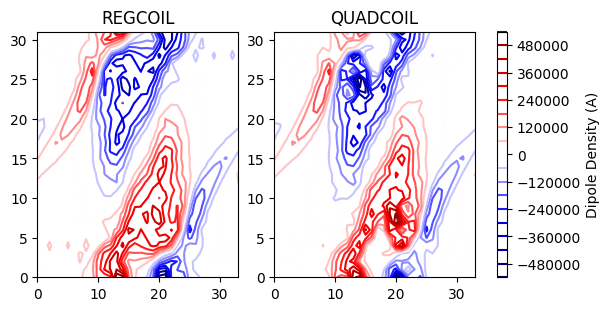

In [12]:
print('f_B from REGCOIL:      ', f_B(regcoili_qp, phi_test_list[i_infl]))
print('f_B from QUADCOIL:     ', f_B(l1_qp, l1_phi_mn))
f_l1_Phi_crtl = f_l1_Phi(regcoili_qp, phi_test_list[i_infl])
f_l1_Phi_l1 = f_l1_Phi(l1_qp, l1_phi_mn)
print('Max dipole dens from REGCOIL:      ', f_l1_Phi_crtl)
print('Max dipole dens from QUADCOIL:     ', f_l1_Phi_l1, round((f_l1_Phi_crtl-f_l1_Phi_l1)/f_l1_Phi_crtl*100, 3), '% improvement')

phi_regcoil = Phi(qp, phi_test_list[i_infl])
phi_quadcoil_l1 = Phi(l1_qp, l1_phi_mn)
cmin = np.min([phi_regcoil, phi_quadcoil])
cmax = np.max([phi_regcoil, phi_quadcoil])

fig, axes = plt.subplots(1, 2, figsize=(6, 3), constrained_layout=True)

# Plot for REGCOIL
im0 = axes[0].contour(phi_regcoil, vmin=cmin, vmax=cmax, cmap = 'seismic', levels=20)
axes[0].set_title('REGCOIL')

# Plot for QUADCOIL
im1 = axes[1].contour(phi_quadcoil_l1, vmin=cmin, vmax=cmax, cmap = 'seismic', levels=20)
axes[1].set_title('QUADCOIL')



# Add colorbar with better positioning
cbar = fig.colorbar(im1, ax=axes, orientation='vertical', shrink=1., aspect=25, pad=0.05)
cbar.set_label("Dipole Density (A)")

plt.show()


### Cumulative distribution function plot
This plot shows the proportion of grid points 
with dipole density $\leq x\% \Phi_{max}$.

<>:19: SyntaxWarning: invalid escape sequence '\P'
<>:20: SyntaxWarning: invalid escape sequence '\l'
<>:19: SyntaxWarning: invalid escape sequence '\P'
<>:20: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_1405312/4046073013.py:19: SyntaxWarning: invalid escape sequence '\P'
  plt.xlabel('Dipole density, as % of $\Phi_{max}$ (A)')
/tmp/ipykernel_1405312/4046073013.py:20: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('CDF (% $\leq$ x)')


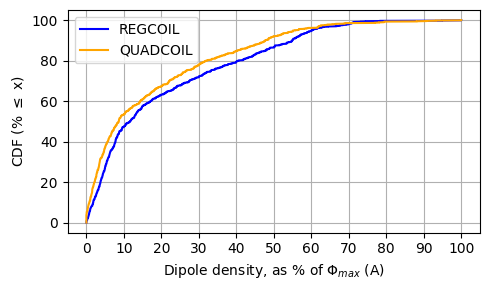

In [13]:

# Flatten arrays
phi_reg = jnp.abs(phi_regcoil.flatten())
phi_quad = jnp.abs(phi_quadcoil_l1.flatten())

# Sort values
phi_reg_sorted = np.sort(phi_reg) / np.max(phi_reg) * 100
phi_quad_sorted = np.sort(phi_quad) / np.max(phi_reg) *100

# Compute CCDFs
ccdf_reg = np.arange(1, len(phi_reg_sorted)+1) / len(phi_reg_sorted)*100
ccdf_quad = np.arange(1, len(phi_quad_sorted)+1) / len(phi_quad_sorted)*100

# Plot
plt.figure(figsize=(5, 3))
plt.plot(phi_reg_sorted, ccdf_reg, label='REGCOIL', color='blue')
plt.plot(phi_quad_sorted, ccdf_quad, label='QUADCOIL', color='orange')
plt.xticks(np.linspace(0, 100, 11))
# Labels and legend
plt.xlabel('Dipole density, as % of $\Phi_{max}$ (A)')
plt.ylabel('CDF (% $\leq$ x)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Taylor test for dipole thickness optimization

In [1]:
plasma_dof_orig = plasma_surface.get_dofs()
plasma_dof_0_list = []
phi_test_list = []
f_max_Phi_test_list = []
f_max_Phi_diff_test_list = []
time_quadcoil_list = []
time_regcoil_list = []
f_max_Phi_df_dplasma_dofs_1_test_list = []
f_max_Phi_df_dplasma_dofs_vihp_test_list = []
f_max_Phi_df_dplasma_dofs_nabla_x_f_test_list = []
f_max_Phi_df_dplasma_dofs_nabla_y_f_test_list = []
f_max_Phi_df_dplasma_dofs_hess_l_k_test_list = []
f_max_Phi_df_dplasma_dofs_2_test_list = []
lam_list = []
mu_list = []
c_list = []
for i in jnp.linspace(-0.1, 0.1, 50):
    plasma_dof_i = plasma_dof_orig.copy()
    plasma_dof_i[0] *= (1 + i)
    # Run QUADCOIL first
    time1 = time.time()
    regcoili_out_dict, regcoili_qp, regcoili_phi_mn, status = quadcoil(
        nfp=plasma_surface.nfp,
        stellsym=plasma_surface.stellsym,
        plasma_coil_distance=separation,
        mpol=mpol,
        ntor=ntor,
        plasma_dofs=plasma_dof_i,
        plasma_mpol=plasma_surface.mpol,
        plasma_ntor=plasma_surface.ntor,
        net_poloidal_current_amperes=net_poloidal_current_amperes,
        net_toroidal_current_amperes=0.,
        metric_name='f_max_Phi',
        objective_name='f_max_Phi2', # Minimizing peak dipole density
        objective_unit=unit_Phi2, # under an f_B constraint
        constraint_name=('f_B',),
        constraint_type=('<=',),
        constraint_unit=(f_B_target,),
        constraint_value=np.array([f_B_target,]),
        verbose=0
        **numerical_kwargs
    )
    block_until_ready(regcoili_phi_mn)
    block_until_ready(regcoili_out_dict)
    block_until_ready(regcoili_qp)
    time2 = time.time()
    time_quadcoil_list.append(time2-time1)
    # REGCOIL ---------------------------------------------------
    time1 = time.time()
    plasma_dof_0_list.append(plasma_dof_i[0])
    phi_test_list.append(regcoili_phi_mn)
    f_max_Phi_test_list.append(regcoili_out_dict['f_max_Phi']['value'])
    f_max_Phi_diff_test_list.append(regcoili_out_dict['f_max_Phi']['grad']['df_dplasma_dofs'][0])
    f_max_Phi_df_dplasma_dofs_1_test_list.append(regcoili_out_dict['f_max_Phi']['grad']['df_dplasma_dofs_1'][0])
    f_max_Phi_df_dplasma_dofs_vihp_test_list.append(regcoili_out_dict['f_max_Phi']['grad']['df_dplasma_dofs_vihp'])
    f_max_Phi_df_dplasma_dofs_nabla_x_f_test_list.append(regcoili_out_dict['f_max_Phi']['grad']['df_dplasma_dofs_nabla_x_f'])
    f_max_Phi_df_dplasma_dofs_nabla_y_f_test_list.append(regcoili_out_dict['f_max_Phi']['grad']['df_dplasma_dofs_nabla_y_f'])
    f_max_Phi_df_dplasma_dofs_hess_l_k_test_list.append(regcoili_out_dict['f_max_Phi']['grad']['df_dplasma_dofs_hess_l_k'])
    f_max_Phi_df_dplasma_dofs_2_test_list.append(regcoili_out_dict['f_max_Phi']['grad']['df_dplasma_dofs_2'][0])
    lam_list.append(status['inner_fin_lam'])
    mu_list.append(status['inner_fin_mu'])
    c_list.append(status['inner_fin_c'])
print('QUADCOIL avg time:', np.average(time_quadcoil_list), '(s)')
print('QUADCOIL max time:', np.max(time_quadcoil_list), '(s)')

NameError: name 'plasma_surface' is not defined

In [ ]:
plasma_dof_0_list = jnp.array(plasma_dof_0_list)
phi_test_list = jnp.array(phi_test_list)
f_max_Phi_test_list = jnp.array(f_max_Phi_test_list)
f_max_Phi_diff_test_list = jnp.array(f_max_Phi_diff_test_list)
time_quadcoil_list = jnp.array(time_quadcoil_list)
time_regcoil_list = jnp.array(time_regcoil_list)
lam_list = jnp.array(lam_list)
mu_list = jnp.array(mu_list)
c_list = jnp.array(c_list)

In [ ]:
plt.plot(plasma_dof_0_list, f_max_Phi_test_list)

In [ ]:
grad_f_max_Phi = jnp.gradient(f_max_Phi_test_list.flatten(), plasma_dof_0_list[1]-plasma_dof_0_list[0])
plt.plot(plasma_dof_0_list, grad_f_max_Phi, label='REGCOIL & numpy.gradient')
plt.plot(plasma_dof_0_list, f_max_Phi_diff_test_list, label='QUADCOIL', linestyle='dashed')
plt.xlabel('$R_{00}$ of plasma surface')
plt.ylabel(r'$\partial \Phi_{max}/\partial R_{00}$ (K$^2$m$^2$)')
plt.legend()
print('Max error:', jnp.max(jnp.abs(grad_f_max_Phi - f_max_Phi_diff_test_list)))
print('Avg error:', jnp.average(jnp.abs(grad_f_max_Phi - f_max_Phi_diff_test_list)))

In [ ]:
plt.plot(c_list, label='c_list')

In [ ]:
plt.plot(lam_list, label='lam_list')

In [ ]:

plt.plot(mu_list, label='mu_list')

In [ ]:

plt.plot(plasma_dof_0_list, grad_f_max_Phi, label='REGCOIL & numpy.gradient')

In [ ]:

plt.plot(plasma_dof_0_list, f_max_Phi_diff_test_list, label='QUADCOIL', linestyle='dashed')